In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip 

In [52]:
!nvidia-smi

Mon May  2 17:14:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   1385MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import os
import numpy as np
from tensorflow.keras.utils import load_img

class ArtLoader:
    """Load in art from artists as an array, batched and ready for tf"""
    
    def __init__(self, data_path):
        """set the path to the data directory"""
        # remove slash if it exists, accounted for in code below
        if data_path[-1] == '/':
            data_path = data_path[:-1]
        self.data_path = data_path

        exclude = ['non-visual artist single images','styles single images', '.DS_Store']
        self.all_artists = [artist for artist in os.listdir(self.data_path) if artist not in exclude]

    def get_all(self, artist_name):
        """read in images from the prompts: 
        'A beautiful painting of a waterlily pond, {artist}, Trending on artstation', 
        'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [load_img(f'{self.data_path}/{artist_name}/{img_path}').convert('RGB') 
                         for img_path in all_img_paths  
                         if img_path.endswith('png')]
        return np.array(pond_img_list)

    def get_ponds(self, artist_name):
        """read in images from the prompt 
        'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [load_img(f'{self.data_path}/{artist_name}/{img_path}').convert('RGB') 
                         for img_path in all_img_paths  
                         if img_path[-5] in ['1', '2', '3']]
        return np.array(pond_img_list)
    
    def get_buildings(self, artist_name):
        """read in images from the prompt 
        'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [img_to_array(load_img(f'{self.data_path}/{artist_name}/{img_path}')) 
                         for img_path in all_img_paths  
                         if img_path[-5] in ['4', '5', '6']]
        return np.array(pond_img_list)

#def get_buildings(artist_path):

In [55]:
import os
from collections import OrderedDict
import IPython.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [56]:
# Torch - features w clip
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# TF  - fetures w resnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

#tf.keras.applications.resnet50.preprocess_input

from tensorflow.keras.utils import img_to_array

#img_to_array()

topless_resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='max' #avg, max
)

model = Sequential([
    Resizing(224, 224),
    topless_resnet
])

In [ ]:
# image_input = torch.tensor(np.stack(images)).cuda()
# text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

# with torch.no_grad():
#     image_features = model.encode_image(image_input).float()
#     text_features = model.encode_text(text_tokens).float()

In [ ]:
# from tensorflow.keras.models import load_model
# clip_image = load_model('../models/clip-image-vit-32-tf')
# #clip_image()

In [9]:
art_loader = ArtLoader(data_path = 'drive/My Drive/datasets/artist_studies/batch 1')
len(art_loader.all_artists)

142

In [57]:
#import tensorflow as tf

#'Robert_Hubert'

artist_features_list = []
art_list = []
artist_list = []

for artist in tqdm(art_loader.all_artists):

    preprocessed_art = []

    for art in art_loader.get_all(artist):
      art_list.append(art)
      preprocessed_art.append(preprocess(art))
    
    image_input = torch.tensor(np.stack(preprocessed_art)).cuda()
    
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
    
    #artist_features = model(artist_ponds).numpy()#.mean(axis = 0)
    
    #resizing_layer = Resizing(224, 224)
    
    #resized_ponds = resizing_layer(artist_ponds)
    
    #print(resized_ponds.preprocessed_art)
    
    # more channels of images
    # (224, 224, 3) -> (3, 224, 224)
    #resized_ponds = np.moveaxis(resized_ponds, -1, 1)
    
    #resized_ponds = tf.cast(resized_ponds, dtype = tf.float16)
    
    
    #print(resized_ponds.shape)
    
    #artist_features = clip_image(input = resized_ponds)
    

    for features in image_features:
        artist_features_list.append(features)
        artist_list.append(artist)

  0%|          | 0/142 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 142/142 [01:15<00:00,  1.88it/s]


In [ ]:
# import tensorflow_transform as tft
# import tensorflow as tf
# results = tft.pca(test_features, 2, tf.float32)

In [58]:
clip_features = np.stack([img_feat.cpu().numpy() for img_feat in artist_features_list])
clip_features.shape

(912, 512)

In [59]:
art_list = np.array(art_list, dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.


In [60]:
art_list.shape

(912,)

In [88]:
colour_feat_list = []
for art in art_list:
  colour_feat_list.append(resize(img_to_array(art), [50,50]))
feat_color_arr = np.stack(colour_feat_list)

In [107]:
colour_features = feat_color_arr.mean(axis = (1, 2))

clip_features.shape
all_features = np.concatenate((colour_features, clip_features), axis = 1)

In [108]:
all_features.shape

(912, 515)

In [109]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
all_features_scaled = s_scaler.fit_transform(all_features)

(array([  6.,  30.,  67., 166., 232., 194., 141.,  60.,  11.,   5.]),
 array([-3.103484  , -2.4629142 , -1.8223445 , -1.1817749 , -0.54120517,
         0.09936452,  0.7399342 ,  1.3805039 ,  2.0210736 ,  2.6616433 ,
         3.302213  ], dtype=float32),
 <a list of 10 Patch objects>)

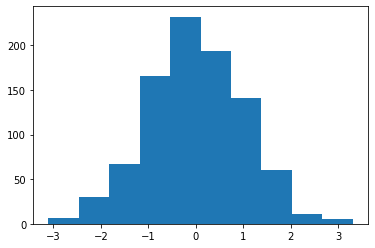

In [111]:
plt.hist(all_features_scaled[:, 3])

In [112]:
import pandas as pd
from sklearn.decomposition import PCA
num_pcs = 100
pca = PCA(num_pcs)
pcs = pca.fit_transform(all_features_scaled)

pcs_dict = {f'pc{i+1}': pcs[:, i] for i in range(num_pcs)}
pcs_dict['artist'] = artist_list

pcs_df = pd.DataFrame(pcs_dict)

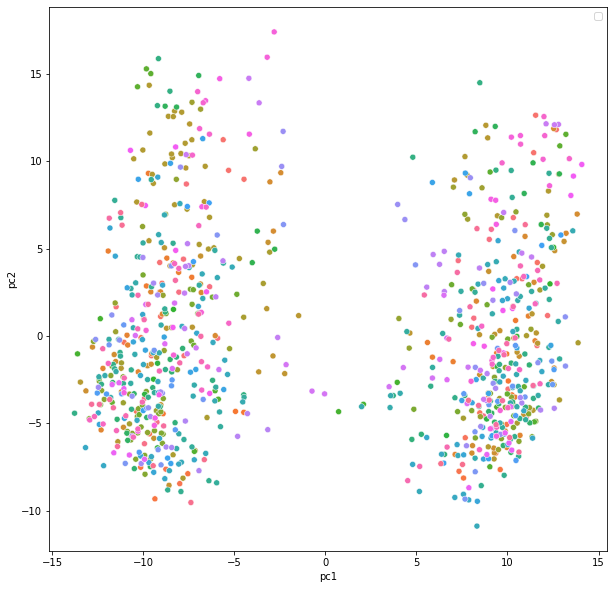

In [113]:
import seaborn as sns
fig , ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(data = pcs_df, x = 'pc1', y = 'pc2', hue = 'artist', ax = ax)
plt.legend('')

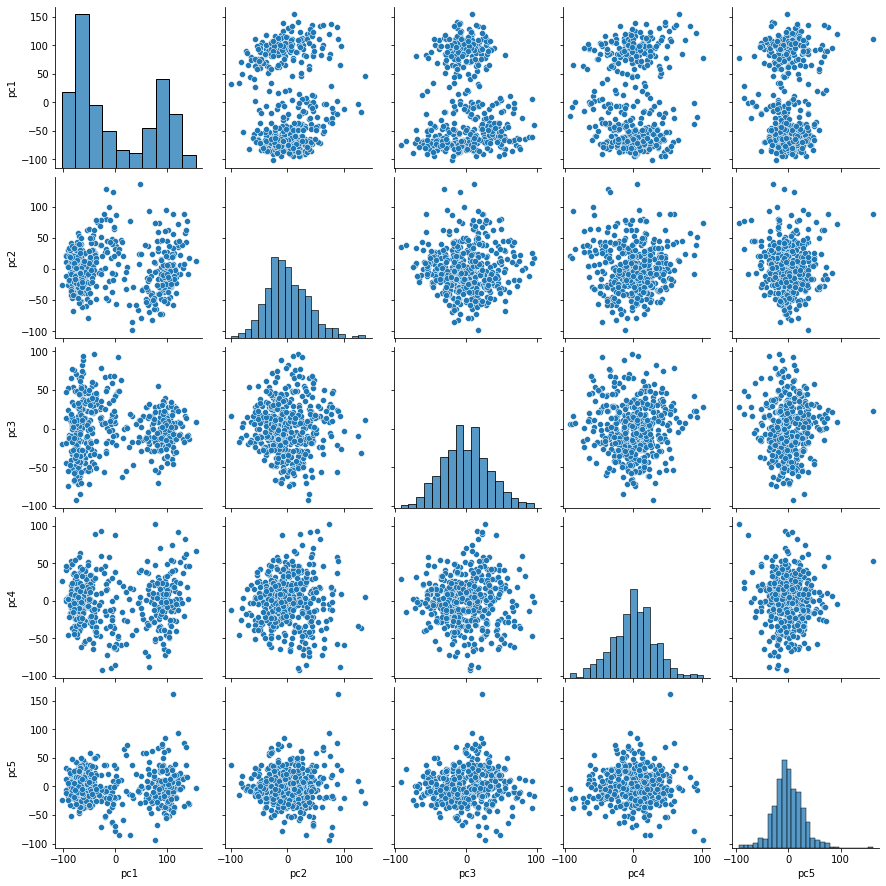

In [ ]:
#sns.pairplot(data = pcs_df)

In [ ]:
## kmeans

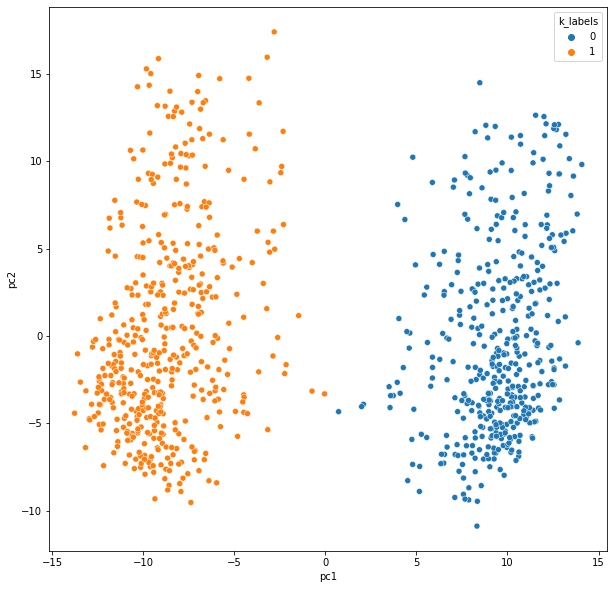

In [124]:
from sklearn.cluster import KMeans
k_cluster = KMeans(2)
k_cluster.fit(pcs)
pcs_df['k_labels'] = k_cluster.labels_

ponds_mask = pcs_df['k_labels'] == 1
ponds = all_features_scaled[ponds_mask]

buildings_mask = pcs_df['k_labels'] == 0
buildings = all_features_scaled[buildings_mask]

fig , ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(data = pcs_df, x = 'pc1', y = 'pc2', hue = 'k_labels', ax = ax)
#plt.legend('')

In [126]:
# pca only ponds
from sklearn.decomposition import PCA
num_pcs = 10
pca = PCA(num_pcs)
pcs_ponds = pca.fit_transform(ponds)

pcs_ponds_dict = {f'pc{i+1}': pcs_ponds[:, i] for i in range(num_pcs)}
pcs_ponds_dict['artist'] = np.array(artist_list)[ponds_mask]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

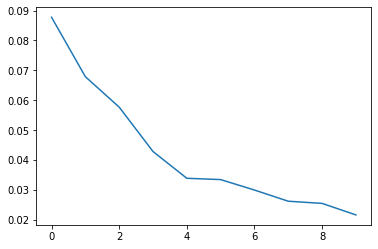

In [127]:
plt.plot(pca.explained_variance_ratio_)

In [128]:
# pca only buildings
from sklearn.decomposition import PCA
num_pcs = 10
pca = PCA(num_pcs)
pcs_buildings = pca.fit_transform(buildings)

pcs_buildings_dict = {f'pc{i+1}': pcs_buildings[:, i] for i in range(num_pcs)}
pcs_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

pcs_buildings_df = pd.DataFrame(pcs_buildings_dict)

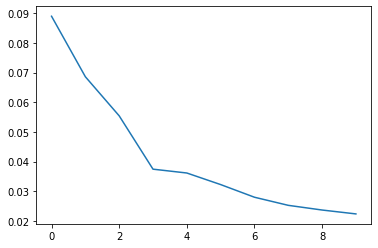

In [136]:
plt.plot(pca.explained_variance_ratio_)

In [129]:
# tsne only ponds
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_ponds = tsne.fit_transform(ponds)

tsne_ponds_dict = {f'pc{i+1}': tsne_ponds[:, i] for i in range(num_tsne)}
tsne_ponds_dict['artist'] = np.array(artist_list)[ponds_mask]

tsne_ponds_df = pd.DataFrame(tsne_ponds_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [138]:
# tsne only buildings
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_buildings = tsne.fit_transform(buildings)

tsne_buildings_dict = {f'pc{i+1}': tsne_buildings[:, i] for i in range(num_tsne)}
tsne_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

tsne_buildings_df = pd.DataFrame(tsne_buildings_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
# import umap

# reducer = umap.UMAP()

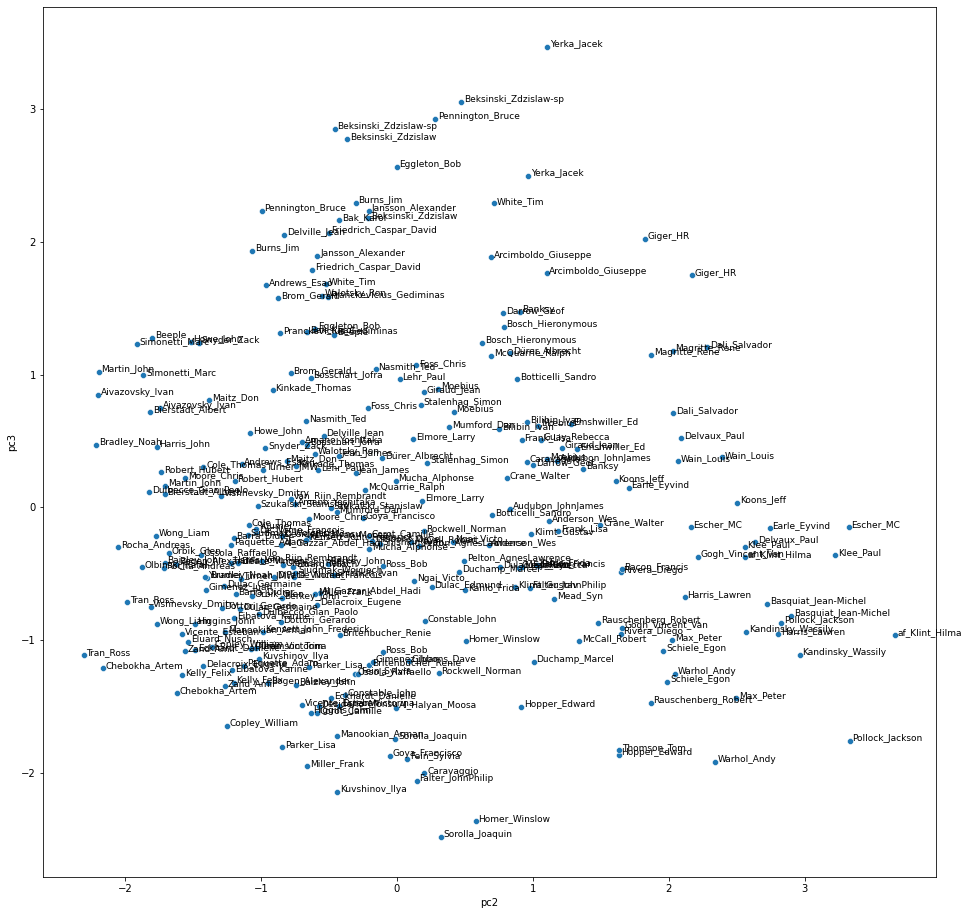

In [67]:
# create labelled scatterplot
artist_df = pcs_df.groupby(['k_labels','artist']).mean().reset_index()

fig , ax = plt.subplots(figsize = (16, 16))
sns.scatterplot(data = artist_df, x = 'pc2', y = 'pc3', ax = ax)

for i, point in artist_df.iterrows():
        ax.text(point['pc2']+.02, point['pc3'], str(point['artist']), size = '9')

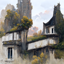

In [ ]:
#from tensorflow.keras.utils import array_to_img
#array_to_img(ponds_list[0]).resize((64, 64))

## plotting images onto pc coords

In [131]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize
from tensorflow.keras.utils import img_to_array

def show_xy_images(in_df, imgs, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for idx, c_row in tqdm(in_df.reset_index().iterrows()):
        #c_img = Image.open(c_row['path']).resize((64, 64))
        c_img = resize(img_to_array(imgs[idx]), [50,50]) / 255.0
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['pc1'], c_row['pc2']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['pc1', 'pc2']])
    ax1.autoscale()
    ax1.axis('off')
#show_xy_images(pcs_df[ponds], imgs = np.array(ponds_list, dtype=object)[ponds])

475it [00:04, 102.67it/s]


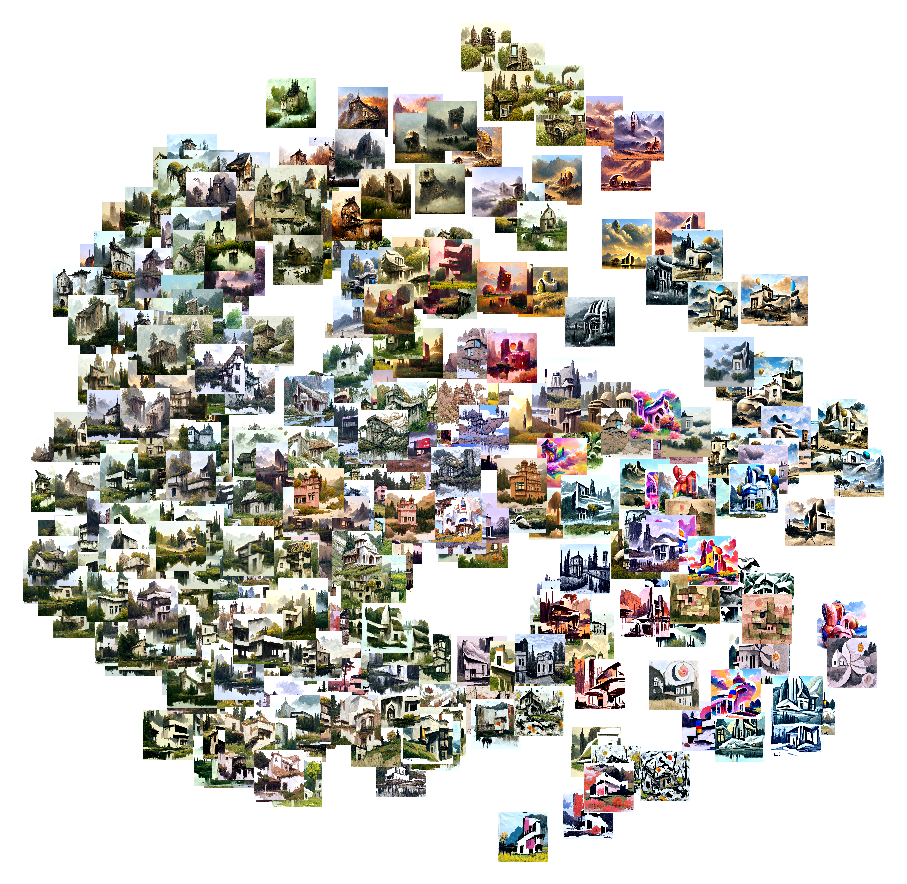

In [132]:
show_xy_images(pcs_ponds_df, imgs = art_list[ponds_mask])

437it [00:04, 96.67it/s]


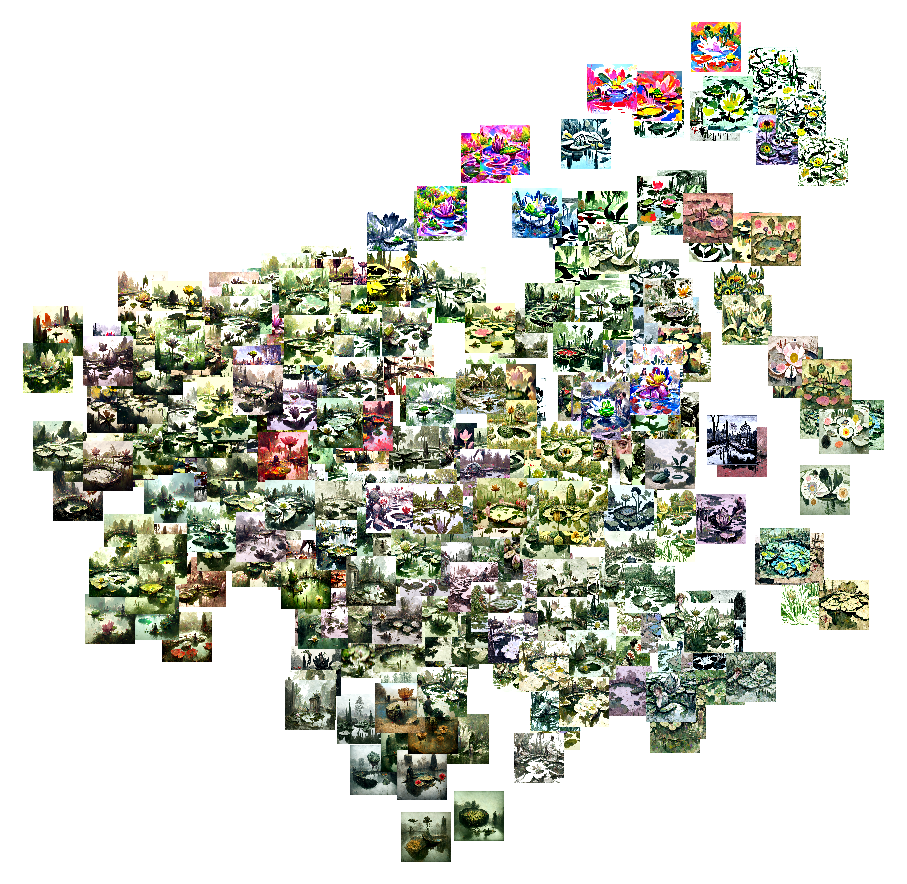

In [133]:
show_xy_images(pcs_buildings_df, imgs = art_list[buildings_mask])

475it [00:04, 108.92it/s]


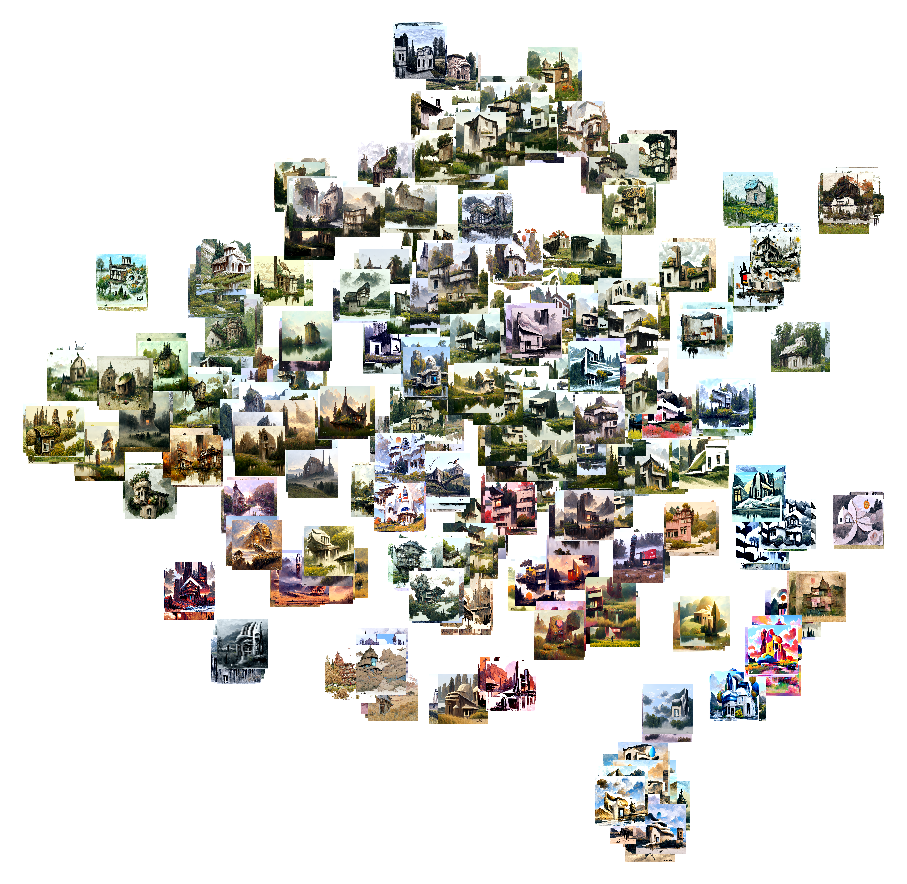

In [139]:
show_xy_images(tsne_ponds_df, imgs = art_list[ponds_mask])

437it [00:03, 109.71it/s]


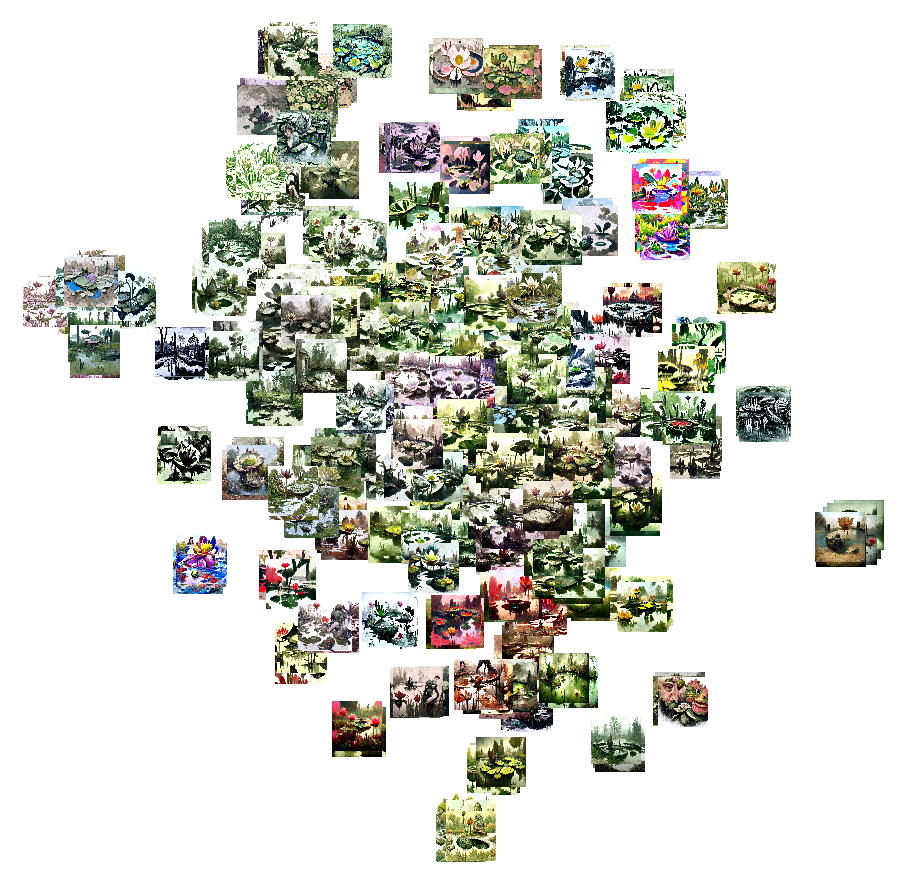

In [140]:
show_xy_images(tsne_buildings_df, imgs = art_list[buildings_mask])

/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_38781/3539781581.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.imshow(np.array(ponds_list)[0].astype(int))


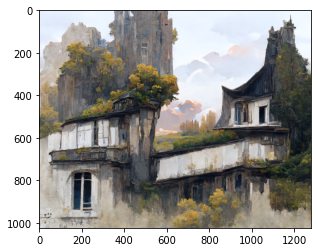

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ponds_list)[0].astype(int))

In [ ]:
# resize
# get features

In [ ]:
# just add pil images to a list, have a later funtion to convert them all to an array

In [ ]:
# preprocess data properly

In [ ]:
# prompts
artist = ""
pond = f'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
building = f'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'

In [ ]:
# idea for showing the images
# https://www.kaggle.com/code/kmader/hurricane-damage-overview

In [ ]:
# def color_count_feature(in_path):
#     raw_image = Image.open(in_path) 
#     web_image = raw_image.convert('P', palette='WEB', dither=None)
#     counts, bins = np.histogram(np.array(web_image).ravel(), bins=np.arange(256))
#     return counts*1.0/np.prod(web_image.size) # normalize output

# image_df['color_features'] = image_df['path'].progress_map(color_count_feature)
